In [1]:
#importing libraries
import math
import pandas as pd
import numpy as np
import os, os.path
import sqlite3
import tempfile 
import seaborn as sns
import matplotlib.pyplot as plt #visualization
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import warnings
from csv import reader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import scipy
from abc import ABCMeta, abstractmethod
from random import seed
from random import randrange
from csv import reader
from math import exp
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import sklearn
#warnings.filterwarnings('ignore')

In [2]:
EPS = 1e-8

In [3]:
#function for detecting collinearity in datasets 
def count_colinear_variables(dataset): 
    corrs = dataset.iloc[:, :-1].corr()
    n_colinear = ((corrs > 0.9).values.flatten().sum() - len(dataset.columns) + 1)/2
    print(f"Dataset has {n_colinear} colinear features")

#dictionary with datasets 
datasets = {'titanic': pd.read_csv('titanic_csv.csv', sep=',', header=None),
            'haberman': pd.read_csv('haberman.data', sep=',', header=None),
            'diabetes': pd.read_csv('pima-indians-diabetes.csv', sep=',', header=None),
            'fertility': pd.read_csv('fertility_csv.csv', sep=',', header=None)}

#changing to the binary data last column from haberman dataset 
haber = datasets['haberman'] 
haber.iloc[:, -1] = haber.iloc[:, -1] - 1
datasets['haberman'] = haber

#detecting colinearity
count_colinear_variables(datasets['titanic'])
count_colinear_variables(datasets['haberman'])
count_colinear_variables(datasets['diabetes'])
count_colinear_variables(datasets['fertility'])

Dataset has 0.0 colinear features
Dataset has 0.0 colinear features
Dataset has 0.0 colinear features
Dataset has 0.0 colinear features


In [4]:
datasets = {dataset_name: dataset.values for dataset_name, dataset in datasets.items()}

In [5]:
# function 
def sigmoid(x):
    return scipy.special.expit(x)

#function calculating logarytmic loss for original y and y predicted
def logloss(y, y_hat):
    return ((-y * np.log(y_hat + EPS)) - (1.0 - y) * np.log(1 - y_hat + EPS)).mean()

def reverse_list(lst):
    return [ele for ele in reversed(lst)]

y = np.array([1,1,1,1,1,1,0,0,0,0,0,0,0,0]) 
y_hat = np.random.uniform(0, 1, size=y.shape) 
logloss(y, y_hat), sklearn.metrics.log_loss(y, y_hat, eps=EPS)

(1.0149219696430347, 1.0149220053676637)

In [6]:
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    return (np.array(actual) == np.array(predicted)).sum()/len(actual)*100

#calculation of recall metric
def recall_metric(actual, predicted):
    TP = len(actual[(actual == 1.0) & (predicted == 1.0)])
    FN = len(actual[(actual == 1.0) & (predicted == 0.0)])
    return 100*TP/(TP+FN) if TP+FN else 0 

#calculation of precision metric
def precision_metric(actual, predicted):
    TP = len(actual[(actual == 1.0) & (predicted == 1.0)])
    FP = len(actual[(actual == 0.0) & (predicted == 1.0)])
    return 100*TP/(FP+TP) if FP+TP else 0

#calculation of F-measure metric
def F_measure_metric(actual, predicted):
    TP = len(actual[(actual == 1.0) & (predicted == 1.0)])
    FP = len(actual[(actual == 0.0) & (predicted == 1.0)])
    FN = len(actual[(actual == 1.0) & (predicted == 0.0)])
    return 100*2*TP/(2*TP + FP + FN) if 2*TP + FP + FN else 0

#function returning rounded metrics in a specified order
def return_metrics(actual, predicted):
    return round(accuracy_metric(actual, predicted), 2),\
            round(recall_metric(actual, predicted), 2),\
            round(precision_metric(actual, predicted), 2),\
            round(F_measure_metric(actual, predicted), 2)


In [7]:
#function for spliting data into tarining and testing subsets 
def split_data(dataset):
    training_data, testing_data = train_test_split(dataset, test_size=0.2, random_state=25)
    train_x = training_data[:, :-1]
    train_y = training_data[:, -1]
    test_x = testing_data[:, :-1]
    test_y = testing_data[:, -1]
    return train_x, train_y, test_x,  test_y

In [8]:
#most basic class with Gradient Descent algorithm implementation
class LR_with_GD: 
    #constructor
    def __init__(self, lr, max_epochs, patience, verbose=0, tolerance=0.1):
        self.lr = lr
        
        self.max_epochs = max_epochs
        self.patience = patience
        
        self.epoch_loss = []
        self.coefs_history = []
        self.accuracy = []
        self.verbose = verbose
        self.gradient_history = []
        self.tolerance = tolerance
        
    #making minibatches for minibatch SGD
    def return_minibatches(self, X, Y, minibatch_size, shuffle=False):
        D = np.concatenate([X, Y.reshape(-1,1)], axis=1)
        if shuffle:
            np.random.shuffle(D)
        for i in range(0, len(D), minibatch_size):
            #print(i, i+minibatch_size)
            yield D[i:i+minibatch_size, :-1],  D[i:i+minibatch_size, -1].reshape(-1, 1)
    
    #function for training the data 
    def fit(self, train_x, train_y):
        try: 
            self.minibatch_size
        except AttributeError: 
            self.minibatch_size = len(train_x)
            
        self.coefs = np.ones(shape=(train_x.shape[1], 1))
        self.t = 1
        for self.num_epoch in range(self.max_epochs):
            for batch_x, batch_y in self.return_minibatches(train_x, train_y, self.minibatch_size):
                y_hat = self.predict_scores(batch_x)
                gradient = self.calculate_gradient(batch_x, batch_y, y_hat)
                self.gradient_history.append(gradient)
                self.update_coefs(gradient)
                self.t += 1
            y_hat = self.predict_scores(train_x)
            y_pred_label = self.predict(train_x)
            

            self.accuracy.append(accuracy_metric(train_y.reshape(-1, 1), y_pred_label.reshape(-1, 1))/100)
            self.epoch_loss.append(logloss(train_y, y_hat))
            self.coefs_history.append(self.coefs)

            #min_epoch_num = np.argmin(self.epoch_loss[:-1])
            min_epoch_loss = min(self.epoch_loss[:-1]) if self.epoch_loss[:-1] else 999999
            
            if min_epoch_loss - self.tolerance < self.epoch_loss[-1]:
                patience_remaining -= 1
            else: 
                patience_remaining = self.patience
            
            
            if patience_remaining == 0:
                if self.verbose > 0:
                    print(f'Epoch {self.num_epoch}, Patience reached')
                break
            else: 
                if self.verbose == 2:
                    print(f'Epoch {self.num_epoch}, {patience_remaining} epochs till patience will be reached')
        else:
            if self.verbose > 0:
                print(f'Patience not reached')
        
        self.coefs = self.coefs_history[np.argmin(self.epoch_loss)]
    
    #function for prediction of scores
    def predict_scores(self, x):
        return sigmoid(x @ self.coefs)
    
    #function for binary prediction
    def predict(self, x): 
        scores = self.predict_scores(x)
        return (scores > 0.5).astype(np.int32)
    
    #updating coeficients with gradient
    def update_coefs(self, gradient):
        self.coefs = self.coefs - self.lr*gradient
        
          
    #calculating gradient 
    def calculate_gradient(self, X, y, y_hat):
        return X.T @ (y_hat - y) / len(y)
    
    #function returning minimum for loss function 
    def return_best_loss_value(self): 
        return min(self.epoch_loss)
    
    #stopping rule for each algorithm
    def return_stopping_epoch(self, patience=None, tolerance=None):
        if patience is None: 
            patience = self.patience
        if tolerance is None: 
            tolerance = self.tolerance
        min_loss = 999999
        patience_remaining = patience
        for idx, epoch_loss in enumerate(self.epoch_loss):
            if epoch_loss + tolerance< min_loss:
                min_loss = epoch_loss
                patience_remaining = patience
            else: 
                patience_remaining -= 1
            
            if patience_remaining == 0 :
                return idx
        return len(self.epoch_loss) - 1
    
#derived class for Stochastic Gradient Descent algorithm implementation
class LR_with_SGD(LR_with_GD):
    #def return_minibatches(self, X, Y, minibatch_size):
    #    D = np.concatenate([X, Y], axis=1)
    #    idx = np.random.randint(0, len(D))
    #    sample = D[idx].reshape(1, -1)
    #    return ((sample[:, :-1],  sample[:, -1].reshape(-1, 1)),)
    
    def return_minibatches(self, X, Y, minibatch_size):
        D = np.concatenate([X, Y.reshape(-1,1)], axis=1)
        for _ in range(len(D)):
            idx = np.random.randint(0, len(D))
            sample = D[idx].reshape(1, -1)
            yield sample[:, :-1],  sample[:, -1].reshape(-1, 1)
            
#derived class for ADAM algorithm implementation    
class LR_with_ADAM(LR_with_GD):
    #additional params in constructor 
    def __init__(self, lr, minibatch_size, max_epochs, patience, beta_1=0.9, beta_2=0.999, verbose=0):
        super().__init__(lr, max_epochs, patience, verbose)
        self.minibatch_size = minibatch_size
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.m_weights, self.v_weights = 0.0, 0.0
    
    #different way of updating coefficient for ADAM 
    def update_coefs(self, gradient): 
        
        self.m_weights = self.beta_1 * self.m_weights + (1.0 - self.beta_1)*gradient
        
        self.v_weights = self.beta_2 * self.v_weights + (1.0 - self.beta_2)*(gradient**2)
        
        m_weights_corr = self.m_weights/(1.0 - self.beta_1**self.t)
        v_weights_corr = self.v_weights/(1.0 - self.beta_2**self.t)
        
        self.coefs = self.coefs - self.lr * (m_weights_corr/(np.sqrt(v_weights_corr)+EPS))
        
    def return_minibatches(self, X, Y, minibatch_size, shuffle=True):
        D = np.concatenate([X, Y.reshape(-1,1)], axis=1)
        if shuffle:
            np.random.shuffle(D)
        for i in range(0, len(D), minibatch_size):
            #print(i, i+minibatch_size)
            yield D[i:i+minibatch_size, :-1],  D[i:i+minibatch_size, -1].reshape(-1, 1)
    
    
#derived class for IRLS algorithm implementation
class LR_with_IRLS(LR_with_GD):
    #constructor 
    def __init__(self, max_epochs, patience, verbose=0):
        super().__init__(1.0, max_epochs, patience, verbose)
    
    #different way to calculate gradient
    def calculate_gradient(self, X, y, y_hat):
        W = np.diag(y_hat.flatten())
        gradient = -np.linalg.inv(X.T @ W @ X + np.identity(X.shape[1])*EPS)@ X.T @ (y-y_hat)
        return gradient

#checking implementation on one dataset with fixed parameters
train_x = datasets['titanic'][:, :-1]
train_y = datasets['titanic'][:, -1]    

model = LR_with_GD(lr=0.00005, max_epochs=1000, patience=250, verbose=1)
model1 = LR_with_SGD(lr=0.000015, max_epochs=1000, patience=250, verbose=1)
model2 = LR_with_ADAM(lr=0.00005, minibatch_size=32, max_epochs=1000, patience=250, verbose=1)
model3 = LR_with_IRLS(max_epochs=1000, patience=250, verbose=1)

train_x = datasets['titanic'][:, :-1]
train_y = datasets['titanic'][:, -1]

model.fit(train_x, train_y)
model1.fit(train_x, train_y)
model2.fit(train_x, train_y)
model3.fit(train_x, train_y)

Epoch 331, Patience reached
Epoch 348, Patience reached
Epoch 250, Patience reached
Epoch 250, Patience reached


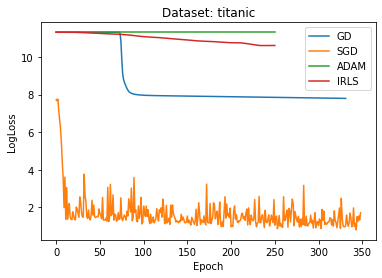

In [9]:
#plotting behaviour of our implemetations of given alorithms 
plt.plot(range(len(model.epoch_loss)), model.epoch_loss, label='GD')
plt.plot(range(len(model1.epoch_loss)), model1.epoch_loss, label='SGD')
plt.plot(range(len(model2.epoch_loss)), model2.epoch_loss, label='ADAM')
plt.plot(range(len(model3.epoch_loss)), model3.epoch_loss, label='IRLS')
plt.title(f'Dataset: titanic')
plt.ylabel('LogLoss')
plt.xlabel('Epoch')
plt.legend()

In [10]:
#checking preformance of implemented metrics           
y_t = np.random.randint(0,2,size=(50,))
y_p = np.random.randint(0,2,size=(50,))
return_metrics(y_t,y_p)

(60.0, 65.38, 60.71, 62.96)

In [11]:
#checking preformance of implemented metrics
accuracy_score(y_t,y_p), recall_score(y_t,y_p),  precision_score(y_t,y_p),f1_score(y_t,y_p) 

(0.6, 0.6538461538461539, 0.6071428571428571, 0.6296296296296297)

- Convergence analysis: check how the value of log-likelihood function depends on the number
of iterations for 4 above algorithms.

In [12]:
lrs = {('titanic', 'GD'): 10e-5,
       ('titanic', 'SGD'): 10e-6,
       ('titanic', 'ADAM'): 10e-3,
       ('haberman', 'GD'): 10e-5,
       ('haberman', 'SGD'): 10e-6,
       ('haberman', 'ADAM'): 10e-3,
       ('diabetes', 'GD'): 10e-5,
       ('diabetes', 'SGD'): 10e-6,
       ('diabetes', 'ADAM'): 10e-3,
       ('fertility', 'GD'): 10e-5,
       ('fertility', 'SGD'): 10e-6,
       ('fertility', 'ADAM'): 10e-3}

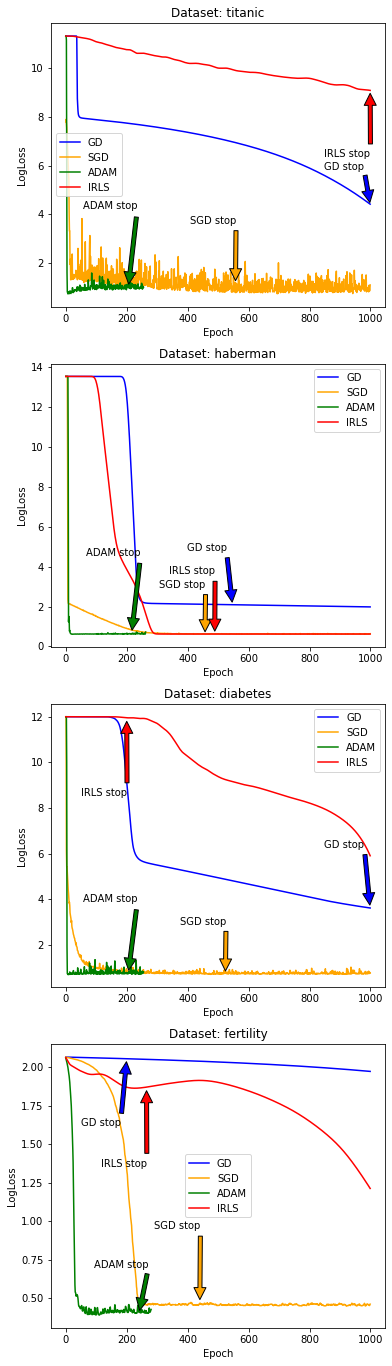

In [40]:
fig, axs = plt.subplots(nrows=len(datasets), ncols=1, figsize=(6,len(datasets)*6))
LRs = {
    'GD': lambda dataset_name: LR_with_GD(lr=lrs[(dataset_name, 'GD')], max_epochs=1000, patience=1000, verbose=0),
    'SGD': lambda dataset_name: LR_with_SGD(lr=lrs[(dataset_name, 'SGD')], max_epochs=1000, patience=1000, verbose=0),
    'ADAM': lambda dataset_name: LR_with_ADAM(lr=lrs[(dataset_name, 'ADAM')], minibatch_size=32, max_epochs=1000, patience=250, verbose=0),
    'IRLS': lambda dataset_name: LR_with_IRLS(max_epochs=1000, patience=1000, verbose=0)}

colors = {'GD': 'blue', 'SGD': 'orange', 'ADAM': 'green', 'IRLS': 'red'}
yranges = {"titanic": 11,"haberman": 14,"diabetes": 12,"fertility": 2}
for i, (dataset_name, dataset) in enumerate(datasets.items()):
    train_x = dataset[:, :-1]
    train_y = dataset[:, -1]
    for optimizer_name, LR in LRs.items():
        model = LR(dataset_name)
        model.fit(train_x, train_y)
        stop_epoch = model.return_stopping_epoch(200)
        axs[i].plot(range(len(model.epoch_loss)), model.epoch_loss, label=optimizer_name, color=colors[optimizer_name])
        #axs[i].scatter([stop_epoch], [model.epoch_loss[stop_epoch]], label=f'{optimizer_name} stop', color=colors[optimizer_name], s=100)
        offset = yranges[dataset_name]*np.random.uniform(0.1, 0.3)
        if yranges[dataset_name] < model.epoch_loss[stop_epoch] + offset:
            y_text = model.epoch_loss[stop_epoch] - offset
        else: 
            y_text = model.epoch_loss[stop_epoch] + offset
        
        axs[i].annotate(f'{optimizer_name} stop', xy=(stop_epoch, model.epoch_loss[stop_epoch]), 
                        xytext=(stop_epoch-150, y_text),
            arrowprops=dict(facecolor=colors[optimizer_name], shrink=0.05))
    axs[i].set_title(f'Dataset: {dataset_name}')
    axs[i].set_ylabel('LogLoss')
    axs[i].set_xlabel('Epoch')
    axs[i].legend()
    
fig.savefig('convergence.png')

Conclusion: The IRLS algorithm is very stable but long one. The GD and ADAM work significantly faster. 

- Check how the value of learning rate and other parameters affect the results.

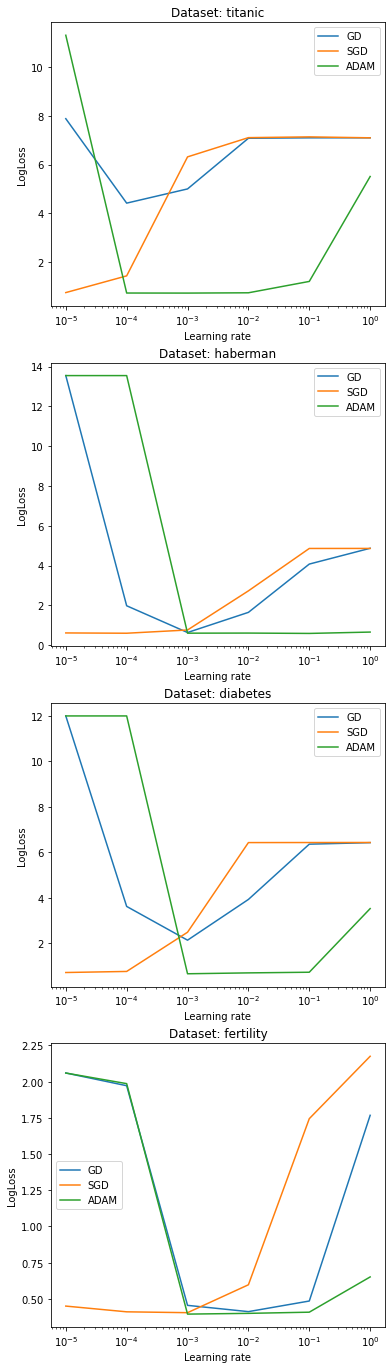

In [17]:
LRs = {
    'GD': lambda lr: LR_with_GD(lr=lr, max_epochs=1000, patience=250, verbose=0),
    'SGD': lambda lr: LR_with_SGD(lr=lr, max_epochs=1000, patience=250, verbose=0),
    'ADAM': lambda lr: LR_with_ADAM(lr=lr, minibatch_size=32, max_epochs=1000, patience=250, verbose=0)}

lrs_values = [10**i for i in range(0, -6, -1)]
lrs_values = reverse_list(lrs_values)

loss_values = {dataset_name: {optimizer_name: [] for optimizer_name in LRs} for dataset_name in datasets}

for lr in lrs_values:
    for dataset_name, dataset in datasets.items():
        train_x = dataset[:, :-1]
        train_y = dataset[:, -1]
        for optimizer_name, LR in LRs.items():
            model = LR(lr)
            model.fit(train_x, train_y)
            loss = model.return_best_loss_value()
            loss_values[dataset_name][optimizer_name].append(loss)
            
fig, axs = plt.subplots(nrows=len(datasets), ncols=1, figsize=(6,len(datasets)*6))
for i, (dataset_name, optimizer_results) in enumerate(loss_values.items()):
    for optimizer_name, loss_values_ in optimizer_results.items():
        axs[i].plot(lrs_values, loss_values_, label=optimizer_name)
    axs[i].set_title(f'Dataset: {dataset_name}')
    axs[i].set_ylabel('LogLoss')
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Learning rate')
    axs[i].legend()
fig.savefig('lr.png')

Plots above shows significant dependance of loss value to learning rate value. The conclusion is that for a specific algorithm there is a treshold of larning rate values with are best suited for a given dataset. For the ADAM algorithm, the log loss value drops significantly for a certain learinig rate and then there is no significant improvement. On the other hand, we have a GD algorithm that clearly has a minimum for a certain learinig rate and then increasing this value causes very rapid increase in log loss.

- adam beta_1 i beta_2 

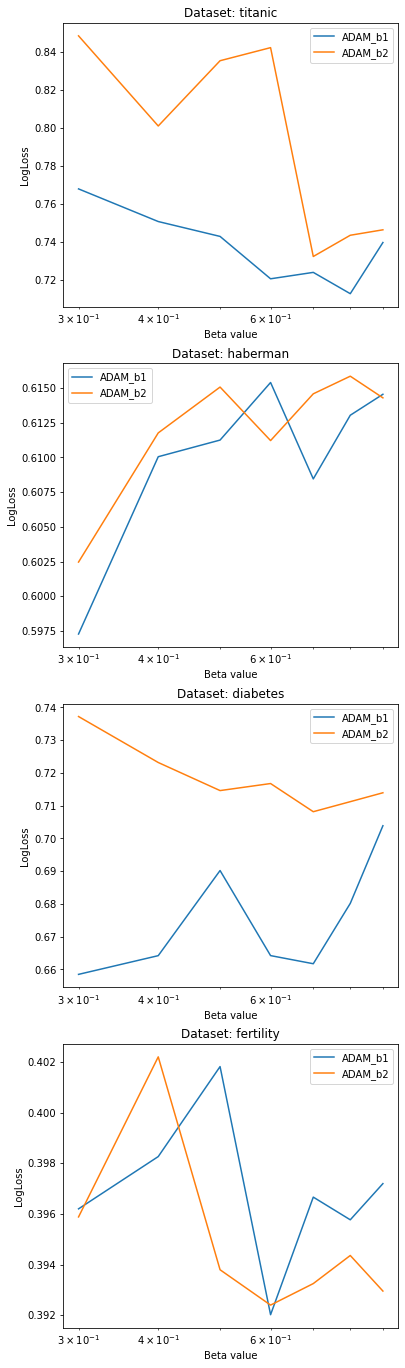

In [25]:
LRs = {'ADAM_b1': lambda beta, dataset_name: LR_with_ADAM(lr=lrs[(dataset_name,'ADAM')], minibatch_size=32, max_epochs=1000, patience=250, verbose=0,beta_1 = beta),
      'ADAM_b2': lambda beta, dataset_name: LR_with_ADAM(lr=lrs[(dataset_name,'ADAM')], minibatch_size=32, max_epochs=1000, patience=250, verbose=0,beta_2 = beta)}

betas = np.arange(0.3, 1, 0.1)

loss_values = {dataset_name: {optimizer_name: [] for optimizer_name in LRs} for dataset_name in datasets}

for beta in betas:
    for dataset_name, dataset in datasets.items():
        train_x = dataset[:, :-1]
        train_y = dataset[:, -1]
        for optimizer_name, LR in LRs.items():
            model = LR(beta, dataset_name)
            model.fit(train_x, train_y)
            loss = model.return_best_loss_value()
            loss_values[dataset_name][optimizer_name].append(loss)
            
fig, axs = plt.subplots(nrows=len(datasets), ncols=1, figsize=(6,len(datasets)*6))
for i, (dataset_name, optimizer_results) in enumerate(loss_values.items()):
    for optimizer_name, loss_values_ in optimizer_results.items():
        axs[i].plot(betas, loss_values_, label=optimizer_name)
    axs[i].set_title(f'Dataset: {dataset_name}')
    axs[i].set_ylabel('LogLoss')
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Beta value')
    axs[i].legend()
fig.savefig('adam_betas1.png')

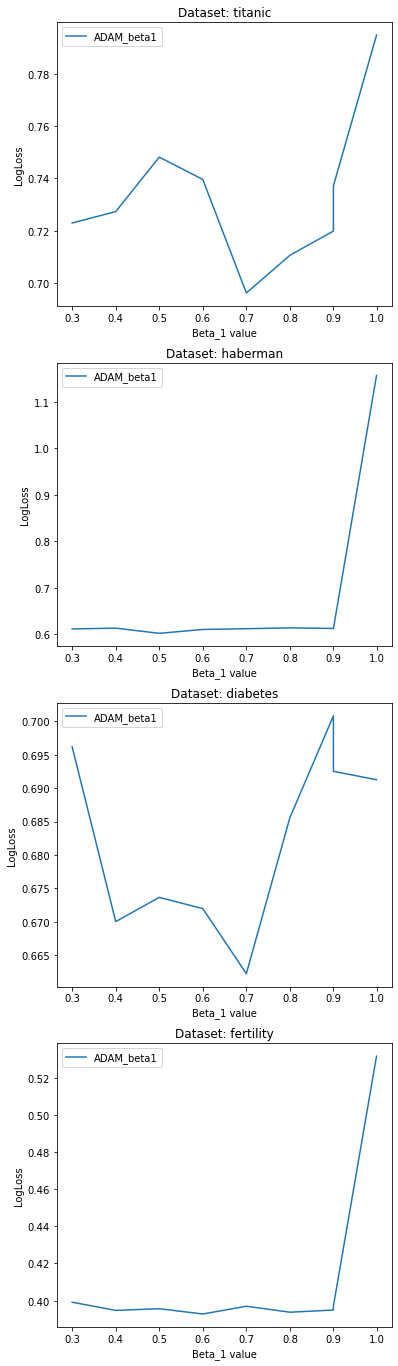

In [15]:
betas_1 = list(np.arange(0.3, 1.0, 0.1)) + [0.9, 0.999]

loss_values = {dataset_name:[] for dataset_name in datasets} 
for beta1 in betas_1:
    for dataset_name, dataset in datasets.items():
        train_x = dataset[:, :-1]
        train_y = dataset[:, -1]
        model = LR_with_ADAM(lr=lrs[(dataset_name, 'ADAM')], minibatch_size=32, max_epochs=1000, patience=250, verbose=0,beta_1 = beta1)
        model.fit(train_x, train_y)
        loss = model.return_best_loss_value()
        loss_values[dataset_name].append(loss)

fig, axs = plt.subplots(nrows=len(datasets), ncols=1, figsize=(6,len(datasets)*6))
for i, (dataset_name,loss_values_) in enumerate(loss_values.items()):
    axs[i].plot(betas_1, loss_values_, label='ADAM_beta1')
    axs[i].set_title(f'Dataset: {dataset_name}')
    axs[i].set_ylabel('LogLoss')
    #axs[i].set_xscale('log')
    axs[i].set_xlabel('Beta_1 value')
    axs[i].legend()
fig.savefig('adam_beta1.png')


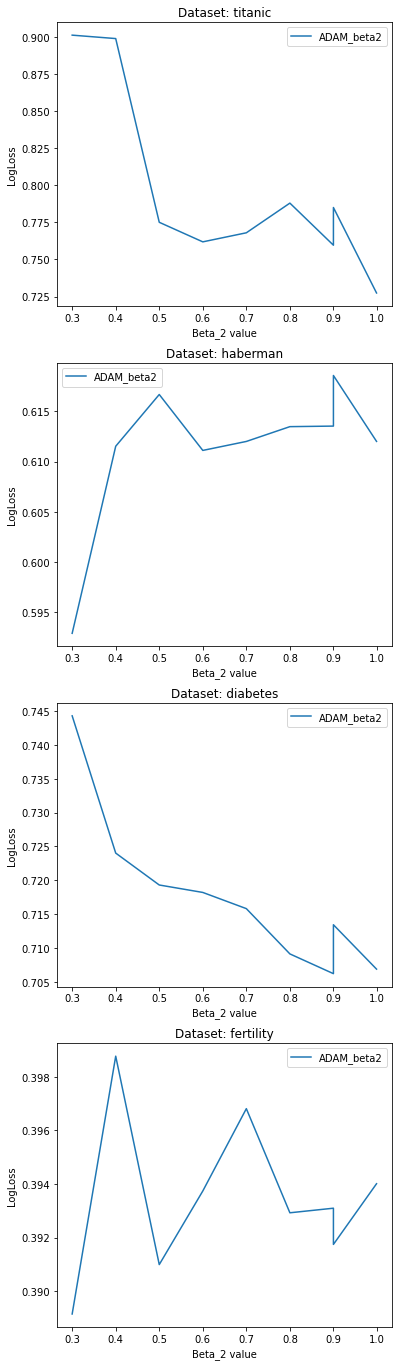

In [16]:
#LRs = {'ADAM_b2': lambda: LR_with_ADAM(lr=0.0005, minibatch_size=32, max_epochs=1000, patience=250, verbose=0)}

betas_2 = list(np.arange(0.3, 1.0, 0.1)) + [0.9, 0.999]

loss_values = {dataset_name:[] for dataset_name in datasets} 
for beta_2 in betas_2:
    for dataset_name, dataset in datasets.items():
        train_x = dataset[:, :-1]
        train_y = dataset[:, -1]
        model = LR_with_ADAM(lr=lrs[(dataset_name, 'ADAM')], minibatch_size=32, max_epochs=1000, patience=250, verbose=0, beta_2=beta_2)
        model.fit(train_x, train_y)
        loss = model.return_best_loss_value()
        loss_values[dataset_name].append(loss)

fig, axs = plt.subplots(nrows=len(datasets), ncols=1, figsize=(6,len(datasets)*6))
for i, (dataset_name, loss_values_) in enumerate(loss_values.items()):
    axs[i].plot(betas_2, loss_values_, label='ADAM_beta2')
    axs[i].set_title(f'Dataset: {dataset_name}')
    axs[i].set_ylabel('LogLoss')
    #axs[i].set_xscale('log')
    axs[i].set_xlabel('Beta_2 value')
    axs[i].legend()
fig.savefig('adam_beta2.png')

- Compare the classification performance of logistic regression (try all 4 methods: IWLS, GD,
SGD and ADAM) and 3 popular classification methods: LDA, QDA and KNN. Use the
performance measures implemented in Part 2 and datasets prepared in Part 1. The
performance measures should be calculated on test set. If the given algorithm does not
converge, within 1000 iterations, stop the algorithm and use the solutions from the last
iteration.


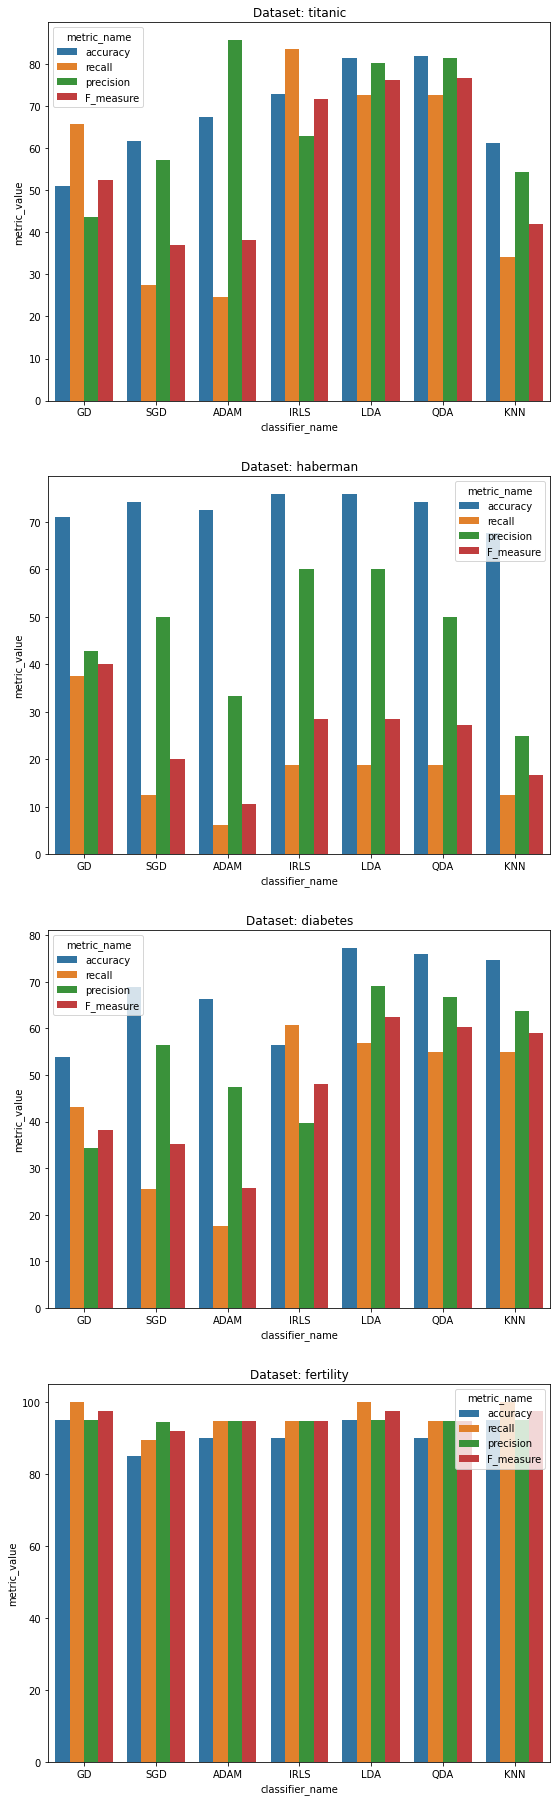

In [21]:
classifiers = {
    'GD': lambda dataset_name: LR_with_GD(lr=lrs[(dataset_name, 'GD')], max_epochs=1000, patience=250, verbose=0),
    'SGD': lambda dataset_name: LR_with_SGD(lr=lrs[(dataset_name, 'SGD')], max_epochs=1000, patience=250, verbose=0),
    'ADAM': lambda dataset_name: LR_with_ADAM(lr=lrs[(dataset_name, 'ADAM')], minibatch_size=32, max_epochs=1000, patience=250, verbose=0),
    'IRLS': lambda _: LR_with_IRLS(max_epochs=1000, patience=250, verbose=0),
    'LDA': lambda _: LinearDiscriminantAnalysis(),
    'QDA': lambda _: QuadraticDiscriminantAnalysis(),
    'KNN': lambda _: KNeighborsClassifier()}

fig, axs = plt.subplots(nrows=len(datasets), ncols=1, figsize=(9,len(datasets)*8))
summary = []
for i, (dataset_name, dataset) in enumerate(datasets.items()):
    accs = []
    recalls = []
    precisions = []
    F_measures = []
    train_x, train_y, test_x,  test_y = split_data(dataset)
    for classifier_name, classifier_ in classifiers.items():
        classifier = classifier_(dataset_name)
        
        
        classifier.fit(train_x, train_y)
        y_pred_test = classifier.predict(test_x)

        accuracy, recall, precision, F_measure = return_metrics(test_y.reshape(-1,1), y_pred_test.reshape(-1,1))
        summary.append((dataset_name, classifier_name,accuracy, 'accuracy'))
        summary.append((dataset_name, classifier_name,recall, 'recall'))
        summary.append((dataset_name, classifier_name,precision, 'precision'))
        summary.append((dataset_name, classifier_name,F_measure, 'F_measure'))

summary = pd.DataFrame(summary, columns=['dataset_name', 'classifier_name', 'metric_value', 'metric_name'])
for i, dataset_name in enumerate(datasets):
    tmp_summary = summary[summary['dataset_name'] == dataset_name]
    sns.barplot(
        data=tmp_summary, x="classifier_name", y="metric_value", hue="metric_name", ax=axs[i])
    axs[i].set_title(f'Dataset: {dataset_name}')
fig.savefig('comparision_with_LDA_QDA_KNN.png')